# Assignment 3: Linear Regression

For this assignment, you may `numpy`, `pandas`, and packages from the Python standard library.

List your team members (name, matriculation number, course of study) in the following cell:

* Your names here

## Task 1: Linear Regression - Theory

Hint: You can enter math in LaTeX style using single dollar signs for inline math, e.g. $x = \cos{\alpha}$, and double dollar signs for equations, e.g.
$$
\begin{align}
\dot{x} &= Ax + Bu\\
y &= Cx + Du
\end{align}
$$

1\) Linear regression can include nonlinear features, why is it still called linear regression? In what sense is it linear?

*Your answer* Linear regression means linear in the parameters, features can be as complex as we want in order to gain more information.

2\) For calculating optimal parameters $\hat{\beta}$ the inverse of $X^\top X$  has to be calculated. When would this matrix be singular?

*Your answer*

3\) Assume optimization of the weights $\hat{\beta}$ fails due to singularity of $X^\top X$. Explain how you would modify $X$ to avoid this problem.

*Your answer*

4\) Why does the optimization problem for $L_1$-regularization (Lasso) generally not have a closed form solution?

*Your answer*

5\) Let us consider a time-series regression problem.

We will look at the model of a lake. Given the water temperature, water conductivity, water alkalinity, NO3 content, and total hardness of the water, we want to predict the dissolved oxygen and algae content in the lake.

The input is defined by $X \in \mathbb{R}^{T \times 5}$ and the output is defined by $Y \in \mathbb{R}^{T \times 2}$. $T$ is the number of time steps, where each time steps corresponds to a month.

We want to predict the output at time step $t+1$ given the input and output at time step $t \in \{0, \dots, T-1 \}$. Formally, defined we need to learn the following function $f$:
$$
\hat{y}_{t+1} = f(x_{t}, y_{t})
$$
where $x_{t}$ is the $t$-th row of $X$ and $y_{t}$ is the $t$-th row of $Y$.

a\) Formally define a linear regression model to estimate the function $f$.

*Your answer*

b\) Dynamic systems, such as the lake in our example, often contain dynamics that are difficult or impossible to measure directly. However, these dynamics can be inferred from long-term time dependencies. For example, the water temperature measured two months ago might still have an impact on the algae content of the lake.

A common feature introduced in models of dynamic systems are lag variables. In this task, you will extend your linear regression model from (a) to include the inputs and outputs of the last two months $t$ and $t-1$  to predict the output at month $t+1$. In this case, the features at time step $t-1$ would be considered lag variables.

Update the function signature of $f$ to match the described prediction task. Then, formally define the linear regression model including the lagged variables.

*Your answer*



## Task 2: Ridge Regression for Time-Series Prediction

In this task, you will implement and evaluate a ridge regression model at the example of the lake model from the previous task. Make sure the provided `lake.dat` file is in the same directory as the Jupyter notebook.

You can find the original data including references here: [DaISy - Data of a simulation of the western basin of Lake Erie](https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_lake_data():
    with open('lake.dat') as f:
        data = np.loadtxt(f)
    X = data[:, 6:11]
    Y = data[:, 23:25]
    return X, Y

def train_test_split(X, Y, train_fraction):
    cutoff_idx = int(train_fraction * X.shape[0])
    X_train, Y_train = X[:cutoff_idx], Y[:cutoff_idx]
    X_test, Y_test = X[cutoff_idx:], Y[cutoff_idx:]

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = train_test_split(*load_lake_data(), train_fraction=0.7)
print(f'Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')


Train samples: 39, Test samples: 18


Training data is stored in `X_train` and `Y_train`. Test data is stored in `X_test` and `Y_test`.

1\) Create a plot that shows all inputs and outputs of the training dataset over time. For each variable a separate subplot should be created. Time should be displayed along the x-axis, while the value of each variable should be displayed along the y-axis.

*Hint:* Use `plt.subplots(n, sharex=True)` to create `n` plots that are synchronized along the x-axis.

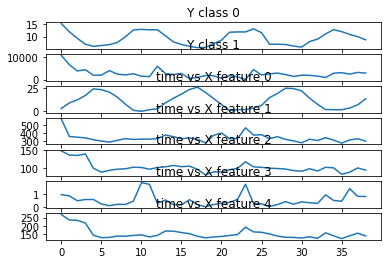

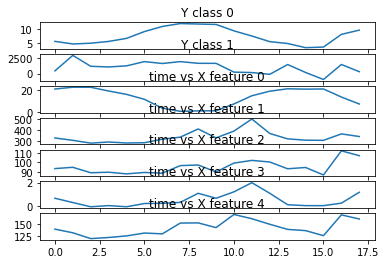

In [3]:
# Your code here
def plot_things(X, Y,label):
    fig,axs=plt.subplots(X.shape[1]+2,sharex=True)
    plt.title(label)
    x_axis=np.arange(X.shape[0])
    axs[0].plot(x_axis,Y[:,0])
    axs[0].set_title('Y class 0')
    axs[1].plot(x_axis,Y[:,1])
    axs[1].set_title('Y class 1')
    for subplot in range(X.shape[1]):
        axs[subplot+2].set_title('time vs X feature ' + str(subplot))
        axs[subplot+2].plot(x_axis,X[:,subplot])
    plt.show()
plot_things(X_train,Y_train,'train data')
plot_things(X_test,Y_test,'test data')

2\) The `make_features` takes as input a matrix of inputs `X` and a matrix of outputs `Y`, as well as the arguments `feature_type` and `lag`.
It computes a features used as input for a linear regression.


`X` has the shape `(T, 5)` and `Y` has the shape `(T, 2)` where `T` is a number of time steps.
`feature_type` is a string with either value `lin` or `quad` whether only linear features or also quadratic features should be computed. `lag` is a boolean that determines whether the lag variables for `t-1`should be included (see Task 1.5).


If `lag` is False, the returned feature matrix has shape `(T, D)` where `D` depends on the choice of `feature_type`.
For `feature_type=lin` and `lag=False`, `D` equals `5+2+1`, for `feature_type=lin` and `lag=True`, `D` equals `2*(5+2)+1`.
If `lag` is True, the returned feature matrix has shape `(T-1, D)`, since the additional lag variable prevents the creation of a feature for time step $t=0$.


Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`) for both `lag=False` and `lag=True`.


In [4]:
def make_features(X, Y, feature_type='lin', lag=False):
    if feature_type == 'lin':
        if lag:
            Phi = np.hstack((
                np.ones((X.shape[0]-1, 1)), # bias/intercept term       # the 1 col
                X[1:], # x_t
                X[:-1], # x_{t-1}           #X is 5 col
                Y[1:], # y_t
                Y[:-1] # y_{t-1}            #Y is 2 col
                #the total is 2(5+2)+1
            ))
        else:
            Phi = np.hstack((
                np.ones((X.shape[0], 1)), # bias/intercept term
                X, # x_t
                Y # y_t
            ))
    elif feature_type == 'quad':#quadratic features
        # Your code here
        A=np.hstack((X[1:],
                    X[:-1]))
        B=np.hstack((Y[1:],
                    Y[:-1]))
        if lag:
            Phi = np.hstack((
                np.ones((X.shape[0]-1,1)),
                A,
                B,
                A*A,
                B*B 
            ))
            
        else:

            Phi = np.hstack((
                np.ones((X.shape[0], 1)),
                X,
                Y,
                X*X,
                Y*Y
            ))
    else:
        raise ValueError(f'feature_type is not implemented for {feature_type}')

    return Phi


3\) Implement ridge regression (linear regression using $L_2$-regularization) to fit a function with the regularization parameter `lambda_`, feature type `feature_type` and optional lag variable `lag`. Use the previously implemented `make_feature` function to allow for different features types and lag variables.

Fill out the methods in `RidgeRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`. Before calculating the inverse check if the determinant is non-zero.

In [5]:
class RidgeRegression:
    def __init__(self, lambda_, feature_type='lin', lag=False):
        self.lambda_ = lambda_
        self.feature_type = feature_type
        self.lag = lag
        self.beta = None  # Learned regression coefficients.

    def fit(self, X, Y):
        """
        X is the time series of inputs with shape (T, 5)
        Y is the time series of outputs with shape (T, 2)
        The goal is to predict the output at t+1 given the input and output at t (or at t and t-1 for lag=True).
        Hint: Your prediction target during training is Y[1:] (or Y[2:] for lag=True).
        """
        # Your code here
        Phi = make_features(X, Y, self.feature_type,self.lag)
        I = np.eye(Phi.shape[1])
        
        if (np.linalg.det(Phi@Phi.T) == 0):
            raise ValueError('Det is 0.')

        X_inv= np.linalg.inv(Phi.T@Phi+self.lambda_*I)@ Phi.T
        
        if self.lag:
            Y=Y[1:]
        else:
            Y=Y[:]
            
        self.beta =X_inv @ Y

    def predict(self, X, Y):
        """
        Predict the next time step for each given row.
        X is the time series of inputs with shape (T, 5)
        Y is the time series of outputs with shape (T, 2)
        The output is of shape (T, 2) (or (T-1, 2) for lag=True).
        """
        # Your code here
        Phi = make_features(X, Y, self.feature_type,self.lag)
        return Phi@self.beta

4\) Evaluate your regression model with linear features (`feature_type='lin'`), no lag (`lag=False`) and no regularization (`lambda_=0.0`). Train the model on `X_train, Y_train` and evaluate it on `X_test, Y_test`.

Compute and report the RMSE separately for both output variables. There should be an error value for dissolved oxygen and algae.

Plot the true and predicted output variables over time similar to task 2.1. The true and predicted output of a variable should be shown in the same subplot for easy comparison.

7.979048281183669e-19


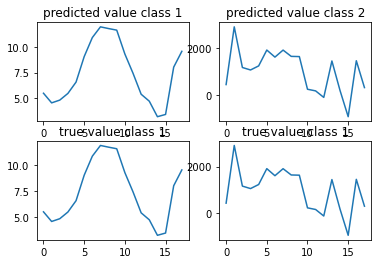

In [6]:
# Your code here
def train_evaluate(regression_model, X_train, y_train, X_test, Y_test):
    regression_model.fit(X_train, Y_train)
    Y_hat= regression_model.predict(X_test, Y_test)
    return Y_hat
    

def plotting( Y_hat, Y_test):
    x_axis=np.arange(Y_hat.shape[0])
    fig, axs = plt.subplots(2,2)
    axs[0,0].plot(x_axis,Y_hat[:,0])
    axs[0,0].set_title('predicted value class 1')
    axs[0,1].plot(x_axis,Y_hat[:,1])
    axs[0,1].set_title('predicted value class 2')
    axs[1,0].plot(x_axis,Y_test[:,0])
    axs[1,0].set_title('true value class 1')
    axs[1,1].plot(x_axis,Y_test[:,1])
    axs[1,1].set_title('true value class 1')
    
    plt.show()
    

regression_linear_false=RidgeRegression(lambda_=0.0,feature_type='lin',lag=False)
Y_hat=train_evaluate(regression_linear_false,X_train,Y_train, X_test, Y_test)

if(Y_hat.shape[0] != Y_test.shape[0]):
    print(np.sum(np.abs(Y_hat-Y_test[1:])**2))
    plotting( Y_hat, Y_test[1:])
else:
    print(np.sum(np.abs(Y_hat-Y_test)**2))
    plotting( Y_hat, Y_test)



## Task 3: Hyperparameter-Optimization with Grid Search

(Not required for B.Sc. Data Science)

In this task, you will look for the optimal combination of hyperparameters for your implemented ridge regression.

Grid search is a simple hyperparameter optimization algorithm, where you train and evaluate your model for each possible combination of hyperparameters out of a predefined set of hyperparameters.
For example, if you apply grid search over kNN, you might search over $k \in \{1, 3, 5\}$ and over weighting schemes $\{\text{uniform}, \text{euclidean}\}$. These choices would result in a total of 6 combinations of hyperparameters.

a\) You will implement a grid search algorithm for your hyperparameters. Search over feature types `lin` and `quad`, both options for `lag`, and various values for `lambda_`. *Hint:* You will have to try some very large values of `lambda_`, since the input and output data is not normalized.

b\) For each combination of feature type and lag, you will create a plot showing the regularization parameter `lambda_` on the x-axis and the RMSE on the y-axis. There should be a total of four plots.

c\) Report the best performing combination of feature type, lag, and regularization.

d\) Finally, shortly discuss your results. How does the regularization and error relate to each other? Why do you think this behavior occurs?

*Hint:* There are two output variables and accordingly two errors for each evaluated model. To simplify the evaluation and hyperparameter optimization, you will have to average these errors to a single error. Note that the output variables have different magnitudes and units, therefore you will have to normalize the variables before computing such an averaged error.

In [7]:
# Your code here